# Market direction classifier
Note: 
* This model is fundamentally flawed due to the Efficients Markets Hypothesis (EMH) which states all available information is already priced into stock data. However, building and backtesting a model like this still provides valuable learning opportunities.
* This notebook is a work in progress 
* This notebook shouldn't be seen as actual trading advice to be applied in reality, more as a learning resource
* Transaction costs aren't taken into account in this model
* The model produces a clearly unrealistic outcome, but I still use it to apply common vectorised back testing techniques as well as leverage and risk analysis

In this work, I import historical candlestick data of EUR/USD exchange values from Twelve Data API. I then calculate returns over each time incriment by averaging Open-Close values. A set of 5 lagged return values are then used to train a SVM classifier to predict the direction of market movements. The dataset is split into a train and test set to reduce overfitting. The test set is used to backtest performance of the model. Estimated returns (excluding transaction costs) are then calculated. An analysist of optimal leverage is then conducted, as well as rudmental risk analysis.

This model is by NO means realistic and little work was done in fine tuning the model and training data. This notebook should be seen more as a learning resources for backtesting, leverage and risk analysis.

In [1]:
import requests
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from config import API_KEY
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns',200)

In [2]:
url = "https://twelve-data1.p.rapidapi.com/time_series"

querystring = {"symbol":"EUR/USD",
               "interval":"15min",
               "outputsize":"5000",
               "format":"json"}

headers = {
	"X-RapidAPI-Key": API_KEY,
	"X-RapidAPI-Host": "twelve-data1.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

# print(response.json())

In [3]:
df_in = pd.json_normalize(response.json()['values'], 
                        meta=['datetime', 'open', 'high', 'low', 'close', ])
df_in[['open', 'high', 'low', 'close', ]] = df_in[['open', 'high', 'low', 'close',]].apply(pd.to_numeric)
df = df_in.copy().iloc[::-1].reset_index(drop=True)
df.drop(index=0)
df

,datetime,open,high,low,close
0,2023-09-22 12:45:00,1.0649,1.06520,1.0644,1.06480
1,2023-09-22 13:00:00,1.0648,1.06520,1.0648,1.06510
2,2023-09-22 13:15:00,1.0652,1.06540,1.0649,1.06500
3,2023-09-22 13:30:00,1.0651,1.06530,1.0650,1.06520
4,2023-09-22 13:45:00,1.0652,1.06530,1.0649,1.06515
...,...,...,...,...,...
4995,2023-12-05 22:00:00,1.0833,1.08370,1.0831,1.08330
4996,2023-12-05 22:15:00,1.0833,1.08350,1.0826,1.08260
4997,2023-12-05 22:30:00,1.0827,1.08270,1.0817,1.08170
4998,2023-12-05 22:45:00,1.0817,1.08195,1.0815,1.08190


Note this data doesn't include the bid-ask spread so we are essentially assuming 0 transaction cost
(An assumption of model - which is incorrect)

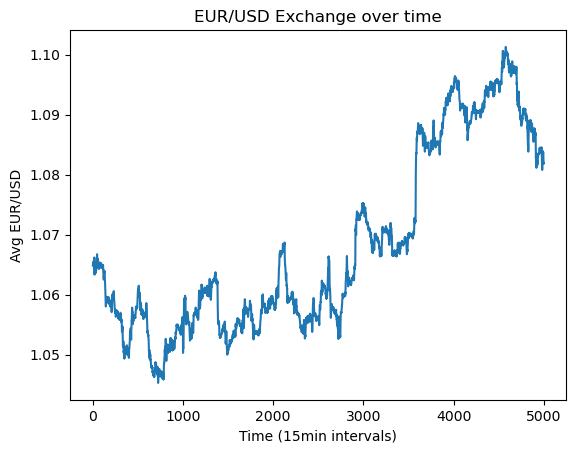

In [4]:
df['avg'] = df[['open','close']].mean(axis=1)
plt.plot(df['avg'])
plt.xlabel('Time (15min intervals)')
plt.ylabel('Avg EUR/USD')
plt.title('EUR/USD Exchange over time');

In [5]:
df['returns'] = np.log(df['avg'] / df['avg'].shift(1)) 
df.dropna(inplace=True)
df['direction'] = np.sign(df['returns']).astype(int)

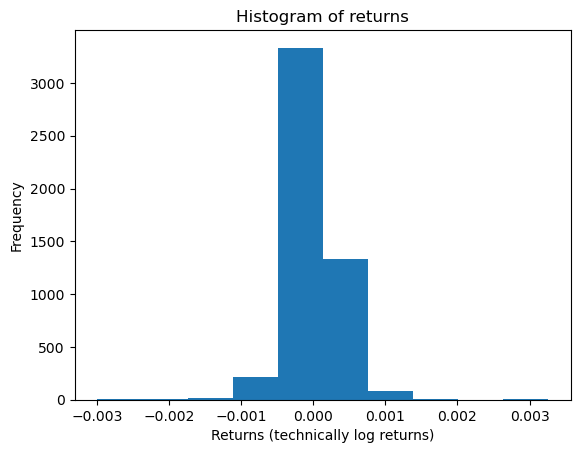

In [6]:
plt.hist(df['returns']);
plt.ylabel('Frequency')
plt.xlabel('Returns (technically log returns)')
plt.title('Histogram of returns');

In [7]:
def add_lagged_columns(df, column_to_lag, num_lags):
    """
    Add lagged columns to a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_to_lag (str): The column for which lagged columns are created.
        num_lags (int): The number of lagged columns to add.
    
    Returns:
        output_df: containing the direction and the lagged returns cols
    """
    cols = []
    for i in range(1, num_lags + 1):
        cols.append(f'{column_to_lag}_lag{i}')
        df[f'{column_to_lag}_lag{i}'] = df[column_to_lag].shift(i)
    return  cols

In [8]:
num_lags = 5
x_cols = add_lagged_columns(df,'returns', num_lags)
df.dropna(inplace=True)
df

,datetime,open,high,low,close,avg,returns,direction,returns_lag1,returns_lag2,returns_lag3,returns_lag4,returns_lag5
6,2023-09-22 14:15:00,1.06560,1.06560,1.0652,1.06530,1.06545,4.692963e-05,1,2.112106e-04,2.347060e-05,4.694285e-05,0.000141,0.000094
7,2023-09-22 14:30:00,1.06540,1.06560,1.0652,1.06550,1.06545,-2.220446e-16,-1,4.692963e-05,2.112106e-04,2.347060e-05,0.000047,0.000141
8,2023-09-22 14:45:00,1.06560,1.06570,1.0652,1.06550,1.06555,9.385265e-05,1,-2.220446e-16,4.692963e-05,2.112106e-04,0.000023,0.000047
9,2023-09-22 15:00:00,1.06545,1.06570,1.0652,1.06545,1.06545,-9.385265e-05,-1,9.385265e-05,-2.220446e-16,4.692963e-05,0.000211,0.000023
10,2023-09-22 15:15:00,1.06550,1.06580,1.0652,1.06540,1.06545,-2.220446e-16,-1,-9.385265e-05,9.385265e-05,-2.220446e-16,0.000047,0.000211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2023-12-05 22:00:00,1.08330,1.08370,1.0831,1.08330,1.08330,-6.923050e-05,-1,-3.922157e-04,1.845529e-04,3.230496e-04,-0.000185,-0.000461
4996,2023-12-05 22:15:00,1.08330,1.08350,1.0826,1.08260,1.08295,-3.231391e-04,-1,-6.923050e-05,-3.922157e-04,1.845529e-04,0.000323,-0.000185
4997,2023-12-05 22:30:00,1.08270,1.08270,1.0817,1.08170,1.08220,-6.927927e-04,-1,-3.231391e-04,-6.923050e-05,-3.922157e-04,0.000185,0.000323
4998,2023-12-05 22:45:00,1.08170,1.08195,1.0815,1.08190,1.08180,-3.696858e-04,-1,-6.927927e-04,-3.231391e-04,-6.923050e-05,-0.000392,0.000185


In [9]:
def fit_models(data):
    mfit = {model: models[model].fit(data[x_cols],data['direction'])
            for model in models.keys()}

def derive_positions(DF):
    for model in models.keys():
        DF['pos_' + model] = models[model].predict(DF[x_cols])

def evaluate_strats(data):
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')
    return sel


In [10]:
# train, test = train_test_split(df, test_size=0.5, shuffle=True, random_state=100)

split = int(len(df) * 0.5)
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()

train = train.copy().sort_index()
test = test.copy().sort_index()

In [11]:
models = {
 'svm': SVC(C=1)
 }

In [12]:
fit_models(train)
derive_positions(test)
sel = evaluate_strats(test)
test[sel].sum().apply(np.exp)

returns      1.024139
strat_svm    1.281570
dtype: float64

In [13]:
print(f'SVM position accuracy in test set: {round(accuracy_score(test['direction'], test['pos_svm'])*100,ndigits=2)}%')

SVM position accuracy in test set: 60.79%


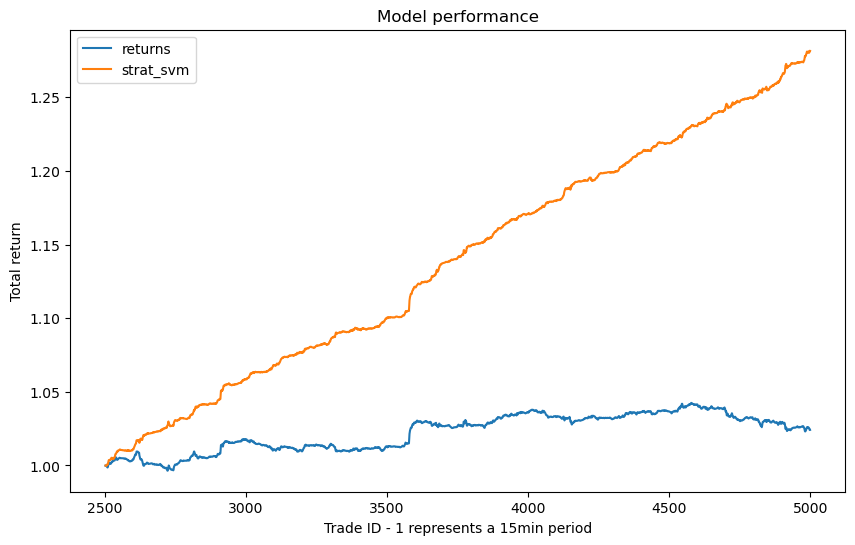

In [14]:
ax = test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.set_xlabel('Trade ID - 1 represents a 15min period')
ax.set_ylabel('Total return')
ax.set_title('Model performance');

In [15]:
my_column_changes = (test["pos_svm"].shift(1) != test["pos_svm"]).sum()
print(f'Total number of trades: {my_column_changes}')



Total number of trades: 1212


This looks somewhat suspicious, 27% returns within about 1 month of trading! Too good to be true?
* Is the model overfit?
* Is this just a chance month? > need to test on longer time periods
* Is the model even valid given EMH?
* Transaction costs required? 1254 trades with a small cost on each could add up.

## Leverage

In [16]:
deltaTime = pd.Timedelta(pd.to_datetime(test.iloc[-1,0]) - pd.to_datetime(test.iloc[0,0])).days
print(f'Days of test set time period: {deltaTime} \nNote EUR/USD only trade 5 days a week and this is total week time')

Days of test set time period: 36 
Note EUR/USD only trade 5 days a week and this is total week time


Rough estimates of annualised log mean return and variance are calculates below.

Note .mean() gives the geometric mean of 15min interval log retruns. Muiltiplying by 96 is because there are 96 15min intervals in a day. And forex trading occurs on all weekdays exlcuing bank holidays (252 trading days a year).

This mean and vol are used to calculate kelly creterion, f* = (mu - r)/sigma^2. I assume here the risk free return rate is 0 for simplicity.

In [17]:
mean = test[['returns', 'strat_svm']].mean() * 96 * 252 
var = test[['returns','strat_svm']].var() * 96 * 252
vol  = var ** 0.5
estimated_kelly = mean/var
print(f'Annualised Mean for passive strat and SVM strat: \n{mean}\n')
print(f'Annulised Variance for passive strat and SVM strat: \n{var}\n')
print(f'Estimated leverage from Kelly Criterion: \n{estimated_kelly}')


Annualised Mean for passive strat and SVM strat: 
returns      0.231087
strat_svm    2.403562
dtype: float64

Annulised Variance for passive strat and SVM strat: 
returns      0.002636
strat_svm    0.002399
dtype: float64

Estimated leverage from Kelly Criterion: 
returns        87.669845
strat_svm    1001.823605
dtype: float64


The estimated optimal leverage from the Kelly Criterion is VERY HIGH, 1000. This is obvisouly unrealistics but is a consquence of the the SVM model itself being unrealistic (the annualised log returns are huge, 2.37!! and variance is very low).

This again is another symptom of the model likely being overfit or perhaps more just a reflection of the training data of the market itself being just a very lucky time to invest i.e. perhaps the training data time period picked is just a strong period in the market timeline. Collecting a wider range of historical data and training on that may bring the model back to reality.

## Problems with Kelly

The kelly crietrion is only valid FOR KNOWN probabilities! When trading we do not know probabilties with certainty, hence why the kelly fraction is not used in practice.

Typical leverage could be around half Kelly values. However, the Kelly value calculated here is way too high, as discussed above, so I simply run the model for leverages of 10,20,30,40 to get a feel for how it performs.

In [18]:
test.head()

,datetime,open,high,low,close,avg,returns,direction,returns_lag1,returns_lag2,returns_lag3,returns_lag4,returns_lag5,pos_svm,strat_svm
2503,2023-10-30 17:30:00,1.0564,1.0564,1.0556,1.0562,1.05630,-0.000095,-1,0.000118,0.000118,0.000142,0.000047,-0.000047,1,-0.000095
2504,2023-10-30 17:45:00,1.0562,1.0566,1.0559,1.0565,1.05635,0.000047,1,-0.000095,0.000118,0.000118,0.000142,0.000047,-1,-0.000047
2505,2023-10-30 18:00:00,1.0564,1.0568,1.0561,1.0564,1.05640,0.000047,1,0.000047,-0.000095,0.000118,0.000118,0.000142,1,0.000047
2506,2023-10-30 18:15:00,1.0564,1.0566,1.0558,1.0560,1.05620,-0.000189,-1,0.000047,0.000047,-0.000095,0.000118,0.000118,1,-0.000189
2507,2023-10-30 18:30:00,1.0559,1.0560,1.0552,1.0557,1.05580,-0.000379,-1,-0.000189,0.000047,0.000047,-0.000095,0.000118,-1,0.000379


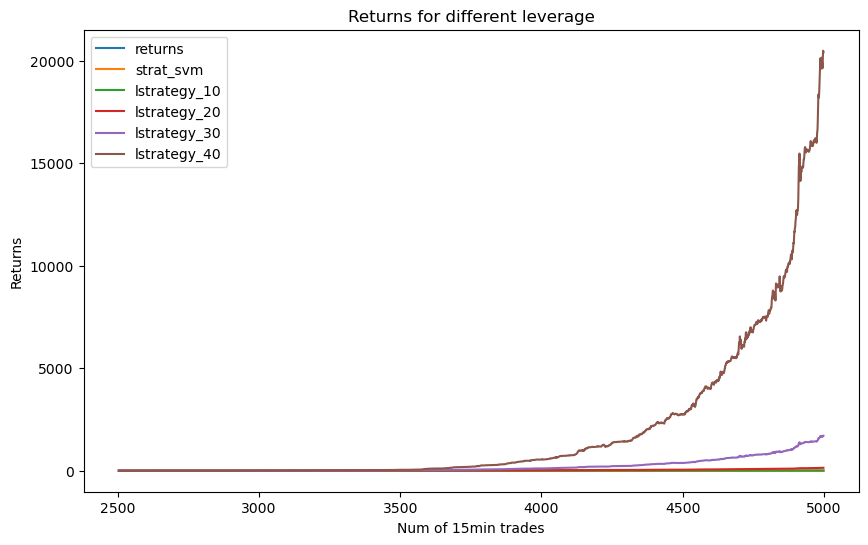

In [19]:
to_plot = ['returns', 'strat_svm']


def leveragePositions(to_plot, leverages, df):
    for lev in leverages:
        label = 'lstrategy_%d' % lev
        df[label] = df['strat_svm'] * lev
        to_plot.append(label)
    return to_plot

to_plot = leveragePositions(to_plot, (10,20,30,40), test)


ax = test[to_plot].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.set_title('Returns for different leverage')
ax.set_xlabel('Num of 15min trades')
ax.set_ylabel('Returns');


### This is clearly silly! Once again the model claims to perform AMAZINGLY, but this is because the model itself is unrealistic!!!! Returns of 10000x are completely unrealistic.

I repeat aagin below but for small leverages

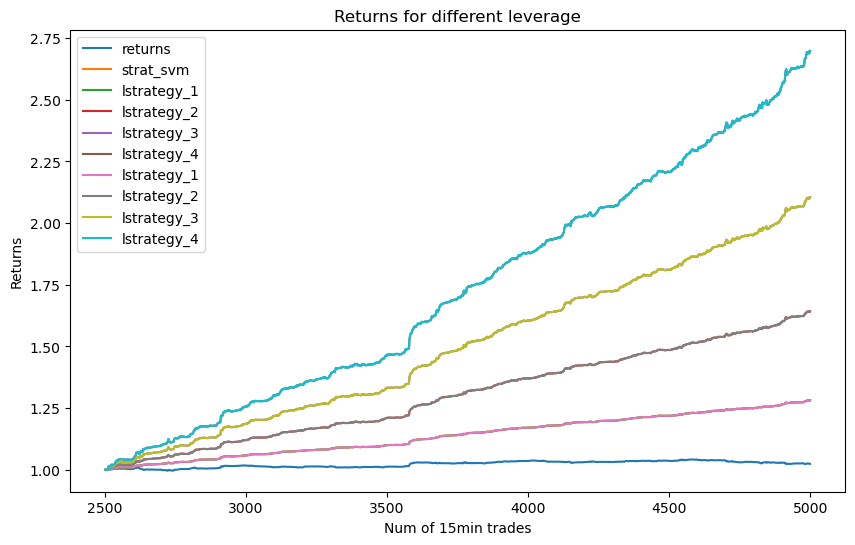

In [20]:
to_plot = ['returns', 'strat_svm']

for lev in [1, 2, 3, 4]:
    label = 'lstrategy_%d' % lev
    test[label] = test['strat_svm'] * lev
    to_plot.append(label)

to_plot = leveragePositions(to_plot, [1,2,3,4], test)

ax = test[to_plot].cumsum().apply(np.exp).plot(figsize=(10, 6))
ax.set_title('Returns for different leverage')
ax.set_xlabel('Num of 15min trades')
ax.set_ylabel('Returns');


# Risk Analysis

This may seem somewhat pointless considering the model has produced unrealistics returns with a low volatility, however this is good practice for other models so I will conduct a few risk analysis tests here anyway (even if they don't reveal much).

First I'll calculate the maximum drawdown and longest drawdown period. 
* Maximum Drawdown is the largest loss (dip) after a high.
* Longest drawdown period is the longest time taken for the trading strategy to get back to a high.


I am going to assume a leverage of 4 to conduct this analysis. So for an equity of $2500 leads to a leveraged position is $10000. I am also assuming there is no change in equity over time, regardless of performance.

In [21]:
equity = 2500
risk = pd.DataFrame(test['lstrategy_4'])
risk['equity'] = risk['lstrategy_4'].cumsum().apply(np.exp) * equity
risk['cummax'] = risk['equity'].cummax()
risk['drawdown'] = risk['cummax'] - risk['equity'] 
max_drawdown = risk['drawdown'].max()
t_max = risk['drawdown'].idxmax()
print(f'Maximum drawdown: {max_drawdown}, occurs at {t_max}')

Maximum drawdown: 59.12024700559596, occurs at 4917


In [22]:
risk

,lstrategy_4,equity,cummax,drawdown
2503,-0.000379,2499.053523,2499.053523,0.000000
2504,-0.000189,2498.580408,2499.053523,0.473115
2505,0.000189,2499.053501,2499.053523,0.000022
2506,-0.000757,2497.161533,2499.053523,1.891991
2507,0.001515,2500.947979,2500.947979,0.000000
...,...,...,...,...
4995,0.000277,6726.445206,6735.140991,8.695784
4996,-0.001293,6717.756514,6735.140991,17.384477
4997,0.002771,6736.398382,6736.398382,0.000000
4998,0.001479,6746.367153,6746.367153,0.000000


In [42]:
temp = risk[risk['drawdown'].isin([0])]
# periods = (temp.index[1:] - temp.index[:-1])
periods = temp.index.to_series().diff()


In [46]:
periods.max()
periods.idxmax()

3457

In [51]:
# pd.set_option('display.max_rows',None)
temp


,lstrategy_4,equity,cummax,drawdown
2503,-0.000379,2499.053523,2499.053523,0.0
2507,0.001515,2500.947979,2500.947979,0.0
2508,0.000758,2502.843893,2502.843893,0.0
2509,0.001326,2506.166068,2506.166068,0.0
2510,0.001232,2509.255882,2509.255882,0.0
...,...,...,...,...
4987,0.002585,6727.682251,6727.682251,0.0
4988,0.000923,6733.893613,6733.893613,0.0
4993,0.000738,6735.140991,6735.140991,0.0
4997,0.002771,6736.398382,6736.398382,0.0


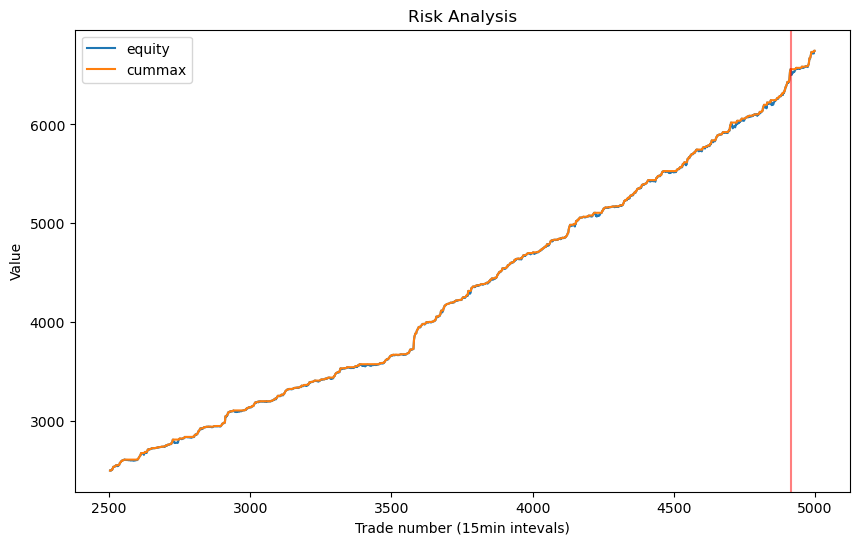

In [59]:
ax = risk[['equity', 'cummax']].plot(figsize=(10, 6))
ax.axvline(t_max, c='r', alpha=0.5)
ax.set_xlabel("Trade number (15min intevals)")
ax.set_ylabel('Value')
ax.set_title('Risk Analysis');

This looks somewhat silly since the model is performing unrealistically.